# Autoencoder with different loss functions

Tasks: Use autoencoders to regenerate images. Explore different loss functions. Which one can successfully regenerate real images?

Okay. Today is Christmas Eve. So I decide to go home to drink beers now!

But I will continue tomorrow. Note this website seems very cool!!!
https://blog.keras.io/building-autoencoders-in-keras.html

Check it. Also complete things you mentioned to Yunhan today.


# 0. Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import util
import statsmodels.api as sm
from scipy import stats
import copy
import pickle

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from datetime import datetime

import util

In [2]:
# ALWAYS choose devise first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
with open('./data_shenhao/nhts/data.pickle', 'rb') as f:
    data_dic = pickle.load(f)
    # note that y is auto usage.

In [4]:
# data
y_train=data_dic['y_train']
y_test=data_dic['y_test']
x_train=data_dic['x_train']
x_test=data_dic['x_test']
train_idx=data_dic['train_idx']
test_idx=data_dic['test_idx']

In [5]:
print(y_train.shape,y_test.shape,x_train.shape,x_test.shape)

(3000,) (800,) (3000, 3, 224, 224) (800, 3, 224, 224)


In [6]:
# a base autoencoder
class Bottleneck(nn.Module):
    # a class used in ResNet.
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        
    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.downsample is not None:
            shortcut = self.downsample(x) # this downsample replaces shortcut.

        out += shortcut
        out = self.relu(out)

        return out

class DeconvBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2, stride=1, upsample=None):
        super(DeconvBottleneck, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if stride == 1:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                   stride=stride, bias=False, padding=1)
        else:
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels,
                                            kernel_size=3,
                                            stride=stride, bias=False,
                                            padding=1,
                                            output_padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # sw: self.expansion rate. 
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.upsample = upsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.upsample is not None:
            shortcut = self.upsample(x) # sw: similarly, upsample replaces shortcut. 

        out += shortcut
        out = self.relu(out)

        return out    


class ResNet_autoencoder(nn.Module):
    def __init__(self, downblock, upblock, num_layers, n_classes):
        super(ResNet_autoencoder, self).__init__()

        # Q: Why is this named as in_channels, when the actual in_channels number = 7?
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False) # 3 channels for rgb
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # downsampling
        self.layer1 = self._make_downlayer(downblock, 64, num_layers[0])
        self.layer2 = self._make_downlayer(downblock, 128, num_layers[1],stride=2)
        self.layer3 = self._make_downlayer(downblock, 256, num_layers[2],stride=2)
        self.layer4 = self._make_downlayer(downblock, 512, num_layers[3],stride=2)
        
        # Q: Is this block (self.fc and self.bn2) used in the autoencoder architecture? 
        # A: No. It is used for the prediction part.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Q: What is the downblock.expansion? Default value = 4. 
        # A: Need to use this expansion to adjust the input dimension. 
        self.fc = nn.Linear(512 * downblock.expansion, n_classes)
        # Q: n_classes are not used?
        # A: It is used.
        self.bn2=nn.BatchNorm1d(1)
        # C: I may want to add another linear module to make the structure symmetric.

        # upsampling
        self.uplayer1 = self._make_up_block(upblock, 512, num_layers[3], stride=2)
        self.uplayer2 = self._make_up_block(upblock, 256, num_layers[2], stride=2)
        self.uplayer3 = self._make_up_block(upblock, 128, num_layers[1], stride=2)
        self.uplayer4 = self._make_up_block(upblock, 64, num_layers[0], stride=2)

        # Q: Was this upsample thing used? 
        # A: I see. Right below in self.uplayer_top 
        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels,  # 256
                               64,
                               kernel_size=1, stride=2,
                               bias=False, output_padding=1),
            nn.BatchNorm2d(64),
        )
        
        self.uplayer_top = DeconvBottleneck(
            self.in_channels, 64, 1, 2, upsample)

        self.conv1_1 = nn.ConvTranspose2d(64, 3, kernel_size=1, stride=1,
                                          bias=False)

    def _make_downlayer(self, block, init_channels, num_layer, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != init_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, init_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(init_channels * block.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, init_channels, stride, downsample))
        self.in_channels = init_channels * block.expansion
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels))

        return nn.Sequential(*layers)

    def _make_up_block(self, block, init_channels, num_layer, stride=1):
        upsample = None
        # expansion = block.expansion
        if stride != 1 or self.in_channels != init_channels * 2:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.in_channels, init_channels * 2,
                                   kernel_size=1, stride=stride,
                                   bias=False, output_padding=1),
                nn.BatchNorm2d(init_channels * 2),
            )
        layers = []
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels, 4))
        layers.append(
            block(self.in_channels, init_channels, 2, stride, upsample))
        self.in_channels = init_channels * 2
        return nn.Sequential(*layers)

    def encoder(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def decoder(self, x, image_size):
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)
        x = self.uplayer4(x)
        x = self.uplayer_top(x)
        # Q: where was the image_size defined? 
        # A: Not really defined. conv1_1 inherits nn.ConvTranspose2d, which has this output_size in the documentation's example.
        x = self.conv1_1(x, output_size=image_size)
        return x

    def forward(self, x):
        img = x
        latten_var = self.encoder(x)
        # Q: again, why do we need this img.size()?
        # A: W
        x_tilde = self.decoder(latten_var, img.size())
#         output=self.classifer(tmp1)
        return x_tilde



In [7]:
# sw: resnet18 structure may be [2,2,2,2]? Right? 
# sw: No. This code is designed for resnet50. The 18 layer arch can work, but not the same as resnet18. 
n_classes=20 # n_classes are now useless. 
model = ResNet_autoencoder(Bottleneck, DeconvBottleneck, [2,2,2,2], n_classes)
model.to(device)

# hyper
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epoch = 30 # change the max n_epoch


In [8]:
# data
x_train_norm = x_train/255 # very crude processing. It is improvable.
x_test_norm = x_test/255 

# processing inputs and outputs 
x_train_torch = torch.from_numpy(x_train_norm)
x_test_torch = torch.from_numpy(x_test_norm)
y_train_torch = torch.from_numpy(x_train_norm) # self image due to autoencoder
y_test_torch = torch.from_numpy(x_test_norm) # self image due to autoencoder

# create data loader: train and test. 
train_ds = TensorDataset(x_train_torch, y_train_torch)
batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

test_ds = TensorDataset(x_test_torch, y_test_torch)
batch_size = 10
test_dl = DataLoader(test_ds, batch_size, shuffle = True)


## Criterion 1 - mean squared error

In [9]:
# MSE loss
criterion = nn.MSELoss(reduction='mean')
# Notes: What are other possibilities? L1Loss.


In [12]:
# MSE loss
criterion = nn.L1Loss(reduction='mean')
# Notes: What are other possibilities?

In [13]:
# training start. 
starting_time = datetime.now()

# mse list
train_list=[]
test_list=[]

for epoch in range(n_epoch):
    running_train = 0.0
    running_test = 0.0

    # training
    for inputs, labels in train_dl:
        # to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward
        outputs = model(inputs)
        # sw: be careful about the dimension matching at this point...
        loss = criterion(outputs, labels) # 
        loss.backward()

        # performance
        running_train += loss.item()*batch_size

        # optimize
        with torch.no_grad():
            optimizer.step()
            optimizer.zero_grad()

    # testing
    for inputs, labels in test_dl:
        # to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward        
        outputs = model(inputs)
        loss = criterion(outputs, labels) # 
        running_test += loss.item()*batch_size # this *batch_size is specific to continuous variables.

    train_list.append(running_train)
    test_list.append(running_test)
            
    print("Epoch {}: Training Loss {}; Testing Loss {}".format(epoch, running_train, running_test))
#     print("Epoch {}: Training R2 {}; Testing R2 {}".format(epoch, running_r_square_train, running_r_square_test))


Epoch 0: Training Loss 332.607049793005; Testing Loss 78.68341319262981
Epoch 1: Training Loss 283.71401213109493; Testing Loss 73.7115453183651
Epoch 2: Training Loss 270.739880874753; Testing Loss 71.95225216448307
Epoch 3: Training Loss 266.7583502084017; Testing Loss 70.32025411725044
Epoch 4: Training Loss 264.54161427915096; Testing Loss 70.30593357980251
Epoch 5: Training Loss 260.4262260347605; Testing Loss 68.57173331081867
Epoch 6: Training Loss 253.87758865952492; Testing Loss 67.89705388247967
Epoch 7: Training Loss 250.5332561582327; Testing Loss 67.18344107270241
Epoch 8: Training Loss 248.24795328080654; Testing Loss 68.3383434265852
Epoch 9: Training Loss 240.73860697448254; Testing Loss 63.26094202697277
Epoch 10: Training Loss 237.28530399501324; Testing Loss 62.06536501646042
Epoch 11: Training Loss 234.51621420681477; Testing Loss 63.5159882158041
Epoch 12: Training Loss 233.29931046813726; Testing Loss 60.767976343631744
Epoch 13: Training Loss 230.96903406083584; 

In [14]:
# timing
ending_time = datetime.now()
difference = ending_time - starting_time
print("Time cost {}".format(difference)) # 20 min for each run!

Time cost 0:17:52.234694


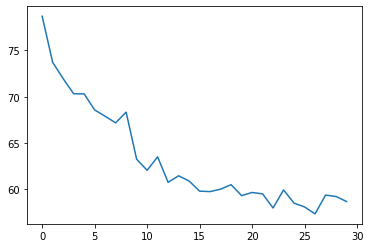

In [15]:
# plt.plot(mse_train_list)
plt.plot(test_list)

# MSE Results Here:

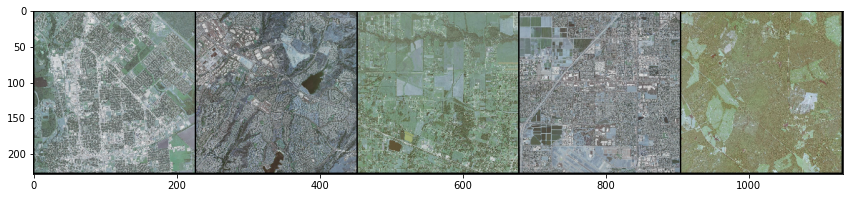

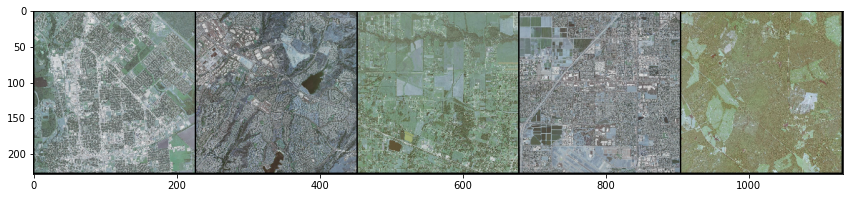

In [29]:
# visualize input images for MSE loss function.
images, images_ = iter(train_dl).next()
vis_five = images[:5,] # visualize five images
vis_five_ = images_[:5,] # visualize five images

def imshow(img):
#     img = img * 255.0     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (15,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # arrange the axis...
    plt.show()


imshow(torchvision.utils.make_grid(vis_five))
imshow(torchvision.utils.make_grid(vis_five_))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


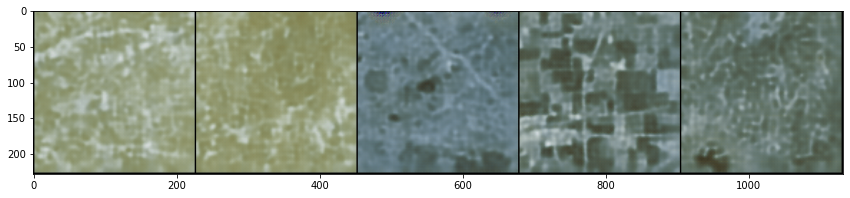

In [20]:
# visualize the reconstructed images.
vis_five_cuba = vis_five.to(device)
vis_five_reconstructed = model(vis_five_cuba)
vis_five_reconstructed_cpu = vis_five_reconstructed.cpu().detach() 
imshow(torchvision.utils.make_grid(vis_five_reconstructed_cpu))

# Q: How to improve the sharpness of the images? 
# Q: How to return the indicators (FIPS) of the images easily? 
# Q: How to fix the exemplary images to obtain intuition? AHHHHHHHH.... ; (


# Criterion 2 - L1 Loss

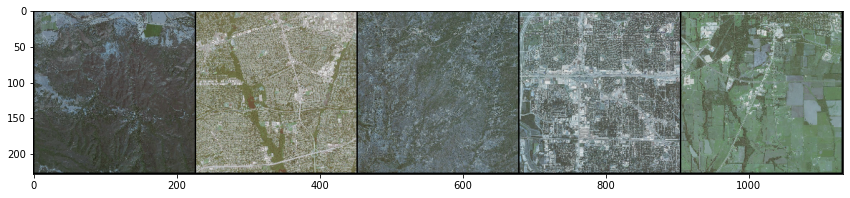

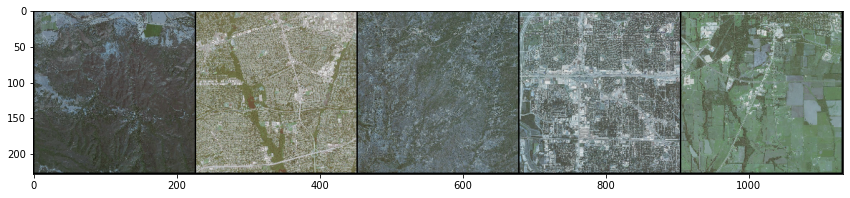

In [16]:
# visualize input images for MSE loss function.
images, images_ = iter(train_dl).next()
vis_five = images[:5,] # visualize five images
vis_five_ = images_[:5,] # visualize five images

def imshow(img):
#     img = img * 255.0     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (15,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # arrange the axis...
    plt.show()

imshow(torchvision.utils.make_grid(vis_five))
imshow(torchvision.utils.make_grid(vis_five_))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


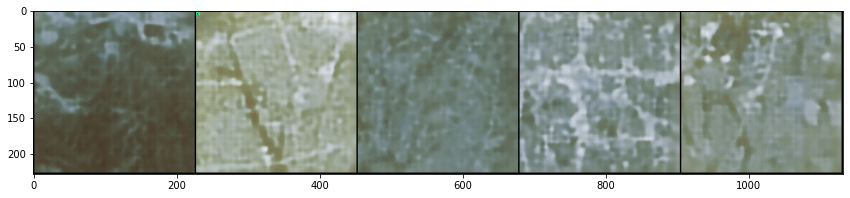

In [17]:
# visualize the reconstructed images.
vis_five_cuba = vis_five.to(device)
vis_five_reconstructed = model(vis_five_cuba)
vis_five_reconstructed_cpu = vis_five_reconstructed.cpu().detach() 
imshow(torchvision.utils.make_grid(vis_five_reconstructed_cpu))

# Analysis

In [ ]:
# try different n_class numbers. How it influence the reconstruction quality. 

In [14]:
datetime.timedelta(seconds=difference)

AttributeError: type object 'datetime.datetime' has no attribute 'timedelta'